# Risk Flag Detection
importing libraries

In [189]:
import pandas as pd
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderQueryError
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn import metrics

In [76]:
# read and save the dataset
# df=pd.read_json('./loan_approval_dataset.json')
df=pd.read_csv('./data.csv')

In [77]:
# set the column names
df.columns=['Id','Income', 'Age', 'Experience', 'Married/Single', 'House_Ownership',
       'Car_Ownership', 'Profession', 'CITY', 'STATE', 'CURRENT_JOB_YRS',
       'CURRENT_HOUSE_YRS', 'Risk_Flag']

In [4]:
df.head()

,Id,Income,Age,Experience,Married/Single,House_Ownership,Car_Ownership,Profession,CITY,STATE,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag
0,1,7574516,40,10,single,rented,no,Software_Developer,Parbhani,Maharashtra,9,13,0
1,2,3991815,66,4,married,rented,no,Technical_writer,Alappuzha,Kerala,4,10,0
2,3,6256451,41,2,single,rented,yes,Software_Developer,Bhubaneswar,Odisha,2,12,1
3,4,5768871,47,11,single,rented,no,Civil_servant,Tiruchirappalli[10],Tamil_Nadu,3,14,1
4,5,6915937,64,0,single,rented,no,Civil_servant,Jalgaon,Maharashtra,0,12,0


In [106]:
# drop id column
df.drop(labels=['Id'],axis=1,inplace=True)

# EDA

In [6]:
df.dtypes

Income                int64
Age                   int64
Experience            int64
Married/Single       object
House_Ownership      object
Car_Ownership        object
Profession           object
CITY                 object
STATE                object
CURRENT_JOB_YRS       int64
CURRENT_HOUSE_YRS     int64
Risk_Flag             int64
dtype: object

In [7]:
df.shape

(251999, 12)

In [8]:
df.isna().sum()

Income               0
Age                  0
Experience           0
Married/Single       0
House_Ownership      0
Car_Ownership        0
Profession           0
CITY                 0
STATE                0
CURRENT_JOB_YRS      0
CURRENT_HOUSE_YRS    0
Risk_Flag            0
dtype: int64

no null values are there in the data

In [9]:
df['Married/Single'].unique()

array(['single', 'married'], dtype=object)

In [10]:
df.House_Ownership.unique()

array(['rented', 'norent_noown', 'owned'], dtype=object)

In [11]:
df.Car_Ownership.unique()

array(['no', 'yes'], dtype=object)

In [12]:
df.Profession.unique(),len(df.Profession.unique())

(array(['Software_Developer', 'Technical_writer', 'Civil_servant',
        'Librarian', 'Economist', 'Flight_attendant', 'Architect',
        'Designer', 'Physician', 'Financial_Analyst',
        'Air_traffic_controller', 'Politician', 'Police_officer', 'Artist',
        'Surveyor', 'Design_Engineer', 'Chemical_engineer',
        'Hotel_Manager', 'Mechanical_engineer', 'Dentist', 'Comedian',
        'Biomedical_Engineer', 'Graphic_Designer',
        'Computer_hardware_engineer', 'Petroleum_Engineer', 'Secretary',
        'Computer_operator', 'Chartered_Accountant', 'Technician',
        'Microbiologist', 'Fashion_Designer', 'Aviator', 'Psychologist',
        'Magistrate', 'Lawyer', 'Firefighter', 'Engineer', 'Official',
        'Analyst', 'Geologist', 'Drafter', 'Statistician', 'Web_designer',
        'Consultant', 'Chef', 'Army_officer', 'Surgeon', 'Scientist',
        'Civil_engineer', 'Industrial_Engineer', 'Technology_specialist'],
       dtype=object),
 51)

In [13]:
df.describe()

,Income,Age,Experience,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag
count,2.519990e+05,251999.000000,251999.000000,251999.000000,251999.000000,251999.000000
mean,4.997131e+06,49.954178,10.084465,6.333890,11.997790,0.123000
std,2.878307e+06,17.063804,6.002585,3.647054,1.399038,0.328438
min,1.031000e+04,21.000000,0.000000,0.000000,10.000000,0.000000
25%,2.503144e+06,35.000000,5.000000,3.000000,11.000000,0.000000
50%,5.000757e+06,50.000000,10.000000,6.000000,12.000000,0.000000
75%,7.477502e+06,65.000000,15.000000,9.000000,13.000000,0.000000
max,9.999938e+06,79.000000,20.000000,14.000000,14.000000,1.000000


### Encoding the categorical features 

In [120]:
# 1 for married 0 for unmarried
df['Married/Single']=df['Married/Single'].apply(lambda x:1 if x=="married" else 0)

In [121]:
# ['rented=0', 'norent_noown=-1', 'owned=1']
def h_owner(x):
    if x=='owned':
        return 1
    elif x=='rented':
        return 0
    else:
        return -1
df['House_Ownership']=df['House_Ownership'].apply(h_owner)

In [122]:
# ['yes=1', 'no=0']
df['Car_Ownership']=df['Car_Ownership'].apply(lambda x:1 if x=='yes' else 0)

In [123]:
df.head()

,Income,Age,Experience,Married/Single,House_Ownership,Car_Ownership,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag,lat,...,Profession_Scientist,Profession_Secretary,Profession_Software_Developer,Profession_Statistician,Profession_Surgeon,Profession_Surveyor,Profession_Technical_writer,Profession_Technician,Profession_Technology_specialist,Profession_Web_designer
0,7574516,40,10,0,0,0,9,13,0,19.262469,...,False,False,True,False,False,False,False,False,False,False
1,3991815,66,4,1,0,0,4,10,0,9.498000,...,False,False,False,False,False,False,True,False,False,False
2,6256451,41,2,0,0,1,2,12,1,20.260296,...,False,False,True,False,False,False,False,False,False,False
3,5768871,47,11,0,0,0,3,14,1,10.804973,...,False,False,False,False,False,False,False,False,False,False
4,6915937,64,0,0,0,0,0,12,0,21.013761,...,False,False,False,False,False,False,False,False,False,False


since dataset is very large we can not directly convert it into logitude and latitute \
so we will collect all the unique addresses and convert them then we will replace in the dataframe

In [78]:
df['STATE'].unique(),len(df['STATE'].unique())

(array(['Maharashtra', 'Kerala', 'Odisha', 'Tamil_Nadu', 'Gujarat',
        'Rajasthan', 'Telangana', 'Bihar', 'Andhra_Pradesh', 'West_Bengal',
        'Haryana', 'Madhya_Pradesh', 'Puducherry', 'Karnataka',
        'Uttar_Pradesh', 'Himachal_Pradesh', 'Punjab', 'Tripura',
        'Uttarakhand', 'Jharkhand', 'Mizoram', 'Assam',
        'Jammu_and_Kashmir', 'Delhi', 'Chhattisgarh', 'Chandigarh',
        'Uttar_Pradesh[5]', 'Manipur', 'Sikkim'], dtype=object),
 29)

29 states are there in the dataset\
let us check which state has most risk flags

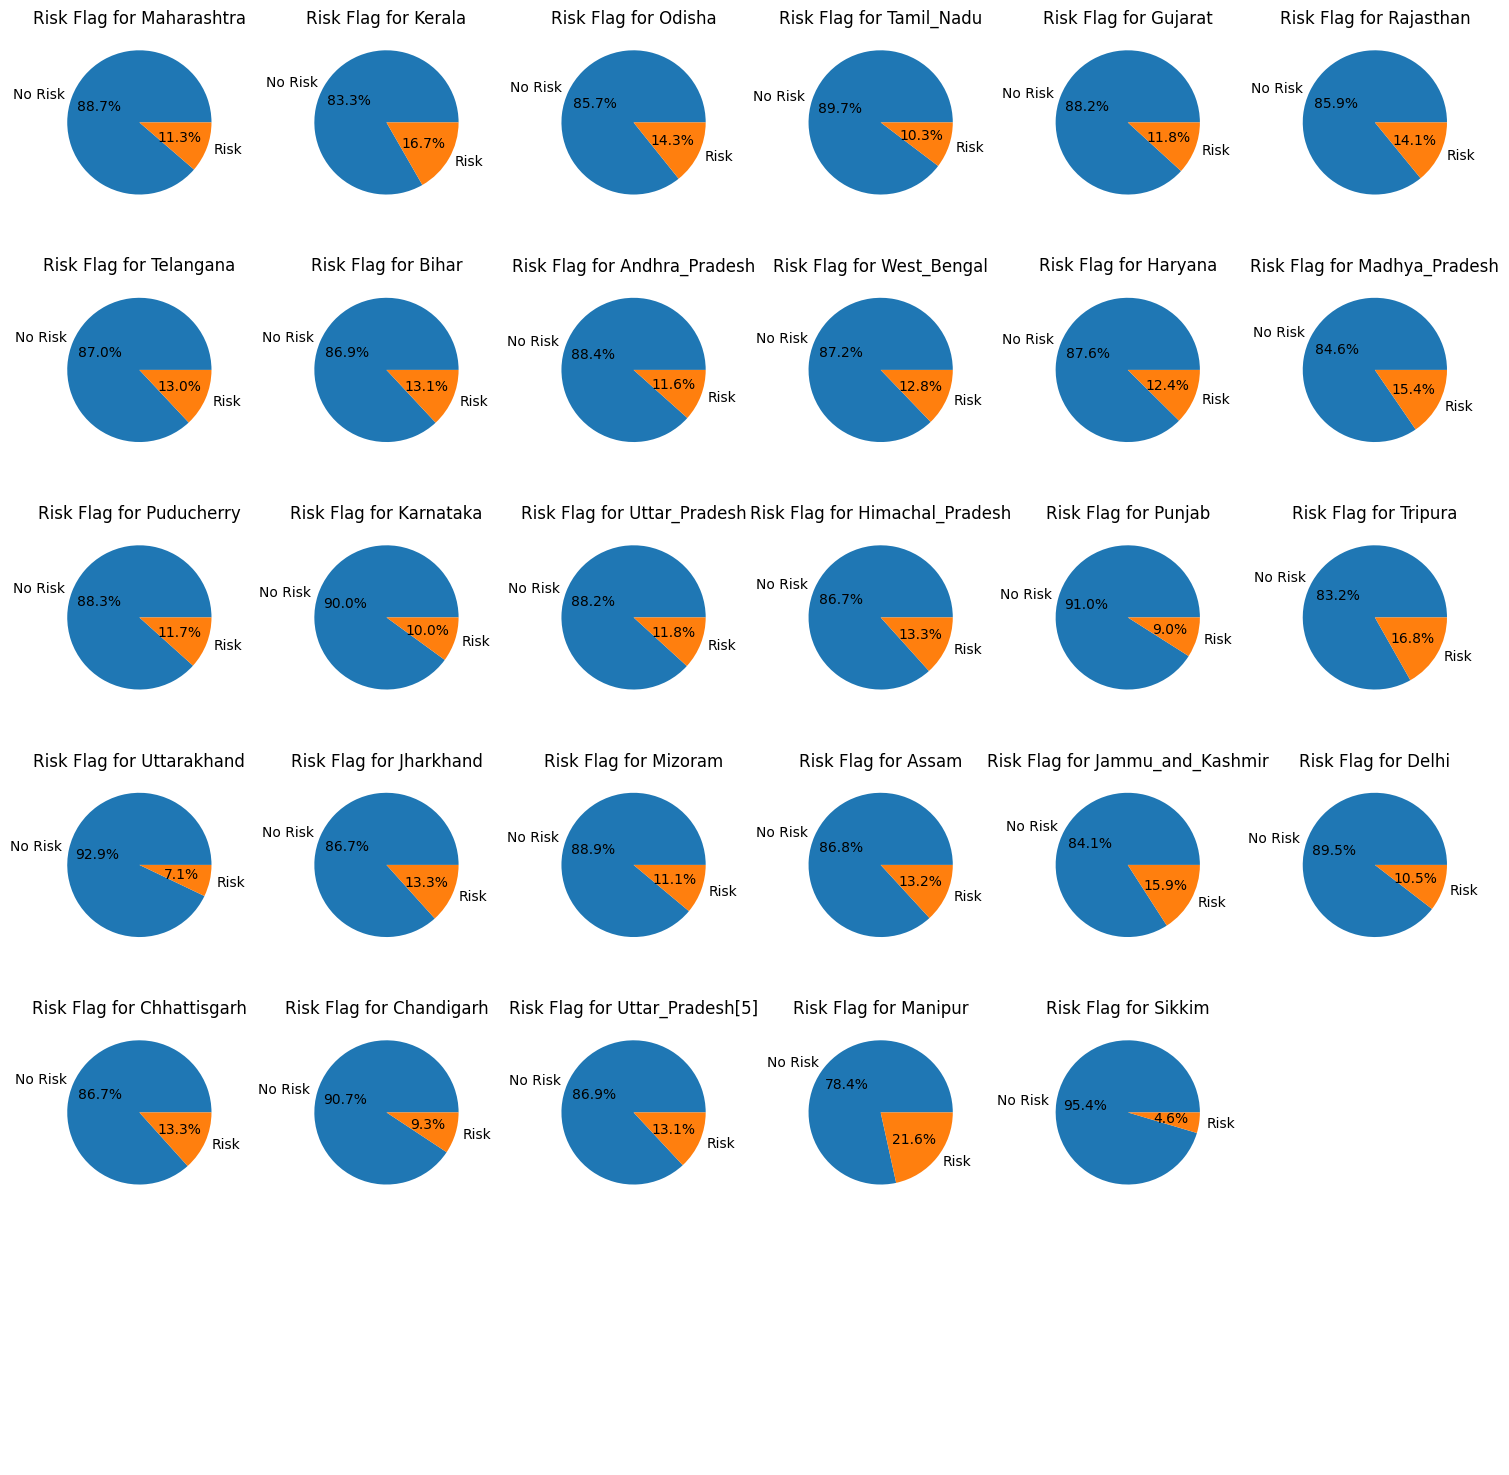

In [83]:
def risk_flag_state(df):
    unique_states = df['STATE'].unique()
    n = len(unique_states)
    # Calculate grid size: sqrt(n) x sqrt(n) or closest approximation
    grid_size = math.ceil(np.sqrt(n))
    
    fig, axs = plt.subplots(grid_size, grid_size, figsize=(15, 15))
    axs = axs.flatten()  # Flatten the array for easy iteration
    
    for i, state in enumerate(unique_states):
        df1 = df[df['STATE'] == state]
        risk_counts = df1['Risk_Flag'].value_counts(normalize=True)
        axs[i].pie(risk_counts, labels=['No Risk', 'Risk'], autopct='%1.1f%%')
        axs[i].set_title(f"Risk Flag for {state}")
    
    # Hide unused subplots if any
    for j in range(i + 1, len(axs)):
        axs[j].axis('off')
    
    plt.tight_layout()
    plt.show()

risk_flag_state(df)

Manipur is most risky state with risk 21.6%.\
Sikkim is least risky state with risk 4.6%.

In [118]:
# clean the city column and state column if needed
def clean_text(x:str):
    x=x.replace('_'," ")
    txt=''
    for ch in x:
        if ch.isalpha() or ch.isspace():
            txt+=ch
    return txt

In [ ]:
df['CITY']=df['CITY'].apply(clean_text)

In [91]:
df['STATE']=df['STATE'].apply(clean_text)

In [92]:
df['address']=df['CITY']+","+df['STATE']+",india"

In [93]:
df.head()

,Id,Income,Age,Experience,Married/Single,House_Ownership,Car_Ownership,Profession,CITY,STATE,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag,address
0,1,7574516,40,10,single,rented,no,Software_Developer,Parbhani,Maharashtra,9,13,0,"Parbhani,Maharashtra,india"
1,2,3991815,66,4,married,rented,no,Technical_writer,Alappuzha,Kerala,4,10,0,"Alappuzha,Kerala,india"
2,3,6256451,41,2,single,rented,yes,Software_Developer,Bhubaneswar,Odisha,2,12,1,"Bhubaneswar,Odisha,india"
3,4,5768871,47,11,single,rented,no,Civil_servant,Tiruchirappalli,Tamil Nadu,3,14,1,"Tiruchirappalli,Tamil Nadu,india"
4,5,6915937,64,0,single,rented,no,Civil_servant,Jalgaon,Maharashtra,0,12,0,"Jalgaon,Maharashtra,india"


In [94]:
address=df['address'].unique()

In [95]:
print(address)

['Parbhani,Maharashtra,india' 'Alappuzha,Kerala,india'
 'Bhubaneswar,Odisha,india' 'Tiruchirappalli,Tamil Nadu,india'
 'Jalgaon,Maharashtra,india' 'Tiruppur,Tamil Nadu,india'
 'Jamnagar,Gujarat,india' 'Kota,Rajasthan,india'
 'Karimnagar,Telangana,india' 'Hajipur,Bihar,india'
 'Adoni,Andhra Pradesh,india' 'Erode,Tamil Nadu,india'
 'Kollam,Kerala,india' 'Madurai,Tamil Nadu,india'
 'Anantapuram,Andhra Pradesh,india' 'Kamarhati,West Bengal,india'
 'Bhusawal,Maharashtra,india' 'Sirsa,Haryana,india'
 'Amaravati,Andhra Pradesh,india' 'Secunderabad,Telangana,india'
 'Ahmedabad,Gujarat,india' 'Ajmer,Rajasthan,india'
 'Ongole,Andhra Pradesh,india' 'Miryalaguda,Telangana,india'
 'Ambattur,Tamil Nadu,india' 'Indore,Madhya Pradesh,india'
 'Pondicherry,Puducherry,india' 'Shimoga,Karnataka,india'
 'Chennai,Tamil Nadu,india' 'Gulbarga,Karnataka,india'
 'Khammam,Telangana,india' 'Saharanpur,Uttar Pradesh,india'
 'Gopalpur,West Bengal,india' 'Amravati,Maharashtra,india'
 'Udupi,Karnataka,india' 'Howrah,

317 toal unique indian addreesses are there

In [27]:
# define geolocator
geolocator = Nominatim(user_agent="geoapi-Exercises")

In [28]:
loc=geolocator.geocode('Bahraich,Uttar Pradesh,india')
print(loc.latitude,loc.longitude)

27.75 81.75


In [29]:
def get_lat_lon_geopy(address):
    try:
        location = geolocator.geocode(address)
        if location:
            return location.latitude, location.longitude
        else:
            print(f"Address not found: {address}")
            return None
    except GeocoderQueryError as e:
        print(f"GeocoderQueryError for address {address}: {e}")
        return None

long_lat = {}
for add in address:
    coords = get_lat_lon_geopy(add)
    if coords:
        long_lat[add] = coords

print(long_lat)


Address not found: KalyanDombivli,Maharashtra,india
Address not found: Surendranagar Dudhrej,Gujarat,india
Address not found: Nangloi Jat,Delhi,india
Address not found: Bhalswa Jahangir Pur,Delhi,india
Address not found: VasaiVirar,Maharashtra,india
Address not found: MiraBhayandar,Maharashtra,india
Address not found: PimpriChinchwad,Maharashtra,india
Address not found: SangliMiraj  Kupwad,Maharashtra,india
Address not found: Sultan Pur Majra,Delhi,india
Address not found: HubliâDharwad,Karnataka,india
Address not found: Raurkela Industrial Township,Odisha,india
{'Parbhani,Maharashtra,india': (19.262469, 76.7718), 'Alappuzha,Kerala,india': (9.4980001, 76.333482), 'Bhubaneswar,Odisha,india': (20.2602964, 85.8394521), 'Tiruchirappalli,Tamil Nadu,india': (10.804973, 78.6870296), 'Jalgaon,Maharashtra,india': (21.0137606, 75.5627048), 'Tiruppur,Tamil Nadu,india': (11.1017815, 77.345192), 'Jamnagar,Gujarat,india': (22.4732415, 70.0552102), 'Kota,Rajasthan,india': (25.1737019, 75.8574194), 'K

these addresses can not be converted because of spelling mistakes or some other reasons. So we have to correct these mistakes manually and retry.

In [65]:
address2={'KalyanDombivli,Maharashtra,india':'Kalyan Dombivli,Maharashtra,india',
          'Surendranagar Dudhrej,Gujarat,india':'Surendranagar Dudhrej,Gujarat,india',
          'Nangloi Jat,Delhi,india':'Nangloi Jat,Delhi,india',
         "Bhalswa Jahangir Pur,Delhi,india":'Bhalswa Jahangir Pur,Delhi,india',
          ' VasaiVirar,Maharashtra,india':' Vasai Virar,Maharashtra,india' ,
          "MiraBhayandar,Maharashtra,india":'Mira Bhayandar,Maharashtra,india',
          "PimpriChinchwad,Maharashtra,india":'Pimpri Chinchwad,Maharashtra,india',
         "SangliMiraj  Kupwad,Maharashtra,india":'Sangli Miraj  Kupwad,Maharashtra,india',
         "Sultan Pur Majra,Delhi,india":'Sultan Pur Majra,Delhi,india',
        "HubliâDharwad,Karnataka,india":'Hubli Dharwad,Karnataka,india',
        "Raurkela Industrial Township,Odisha,india":'Raurkela,Odisha,india',}

In [31]:
for add1,add2 in address2.items():
    coords = get_lat_lon_geopy(add2)
    if coords:
        long_lat[add1] = coords

Address not found: Surendranagar Dudhrej,Gujarat,india
Address not found: Nangloi Jat,Delhi,india
Address not found: Bhalswa Jahangir Pur,Delhi,india
Address not found: Sultan Pur Majra,Delhi,india


In [32]:
# we can use google search for these addresses
long_lat['Surendranagar Dudhrej,Gujarat,india']=(22.7271,71.6485)
long_lat['Nangloi Jat,Delhi,india']=(28.6849,77.0689)
long_lat['Bhalswa Jahangir Pur,Delhi,india']=(25.257428,85.751975)
long_lat["Sultan Pur Majra,Delhi,india"]=(29.029486,76.925703)
long_lat['Raurkela Industrial Township,Odisha,india']=(22.2494,84.8828)
long_lat['VasaiVirar,Maharashtra,india']=(20.502147,75.664579)

In [96]:
# store the lat and long in the dataframe
df['lat']=df['address'].map(lambda x:long_lat[x][0] if x in long_lat else None)

In [97]:
df['lon']=df['address'].map(lambda x:long_lat[x][1] if x in long_lat else None)

In [98]:
df.head()

,Id,Income,Age,Experience,Married/Single,House_Ownership,Car_Ownership,Profession,CITY,STATE,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag,address,lat,lon
0,1,7574516,40,10,single,rented,no,Software_Developer,Parbhani,Maharashtra,9,13,0,"Parbhani,Maharashtra,india",19.262469,76.771800
1,2,3991815,66,4,married,rented,no,Technical_writer,Alappuzha,Kerala,4,10,0,"Alappuzha,Kerala,india",9.498000,76.333482
2,3,6256451,41,2,single,rented,yes,Software_Developer,Bhubaneswar,Odisha,2,12,1,"Bhubaneswar,Odisha,india",20.260296,85.839452
3,4,5768871,47,11,single,rented,no,Civil_servant,Tiruchirappalli,Tamil Nadu,3,14,1,"Tiruchirappalli,Tamil Nadu,india",10.804973,78.687030
4,5,6915937,64,0,single,rented,no,Civil_servant,Jalgaon,Maharashtra,0,12,0,"Jalgaon,Maharashtra,india",21.013761,75.562705


In [99]:
df.isna().sum()

Id                   0
Income               0
Age                  0
Experience           0
Married/Single       0
House_Ownership      0
Car_Ownership        0
Profession           0
CITY                 0
STATE                0
CURRENT_JOB_YRS      0
CURRENT_HOUSE_YRS    0
Risk_Flag            0
address              0
lat                  0
lon                  0
dtype: int64

In [100]:
df['Profession'].unique(),len(df['Profession'].unique())

(array(['Software_Developer', 'Technical_writer', 'Civil_servant',
        'Librarian', 'Economist', 'Flight_attendant', 'Architect',
        'Designer', 'Physician', 'Financial_Analyst',
        'Air_traffic_controller', 'Politician', 'Police_officer', 'Artist',
        'Surveyor', 'Design_Engineer', 'Chemical_engineer',
        'Hotel_Manager', 'Mechanical_engineer', 'Dentist', 'Comedian',
        'Biomedical_Engineer', 'Graphic_Designer',
        'Computer_hardware_engineer', 'Petroleum_Engineer', 'Secretary',
        'Computer_operator', 'Chartered_Accountant', 'Technician',
        'Microbiologist', 'Fashion_Designer', 'Aviator', 'Psychologist',
        'Magistrate', 'Lawyer', 'Firefighter', 'Engineer', 'Official',
        'Analyst', 'Geologist', 'Drafter', 'Statistician', 'Web_designer',
        'Consultant', 'Chef', 'Army_officer', 'Surgeon', 'Scientist',
        'Civil_engineer', 'Industrial_Engineer', 'Technology_specialist'],
       dtype=object),
 51)

51 unique professions are there

In [101]:
# one hot encoding for profession
df=pd.get_dummies(df,columns=['Profession'])

In [107]:
df.head()

,Income,Age,Experience,Married/Single,House_Ownership,Car_Ownership,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag,lat,...,Profession_Scientist,Profession_Secretary,Profession_Software_Developer,Profession_Statistician,Profession_Surgeon,Profession_Surveyor,Profession_Technical_writer,Profession_Technician,Profession_Technology_specialist,Profession_Web_designer
0,7574516,40,10,single,rented,no,9,13,0,19.262469,...,False,False,True,False,False,False,False,False,False,False
1,3991815,66,4,married,rented,no,4,10,0,9.498000,...,False,False,False,False,False,False,True,False,False,False
2,6256451,41,2,single,rented,yes,2,12,1,20.260296,...,False,False,True,False,False,False,False,False,False,False
3,5768871,47,11,single,rented,no,3,14,1,10.804973,...,False,False,False,False,False,False,False,False,False,False
4,6915937,64,0,single,rented,no,0,12,0,21.013761,...,False,False,False,False,False,False,False,False,False,False


In [103]:
df.columns  

Index(['Id', 'Income', 'Age', 'Experience', 'Married/Single',
       'House_Ownership', 'Car_Ownership', 'CITY', 'STATE', 'CURRENT_JOB_YRS',
       'CURRENT_HOUSE_YRS', 'Risk_Flag', 'address', 'lat', 'lon',
       'Profession_Air_traffic_controller', 'Profession_Analyst',
       'Profession_Architect', 'Profession_Army_officer', 'Profession_Artist',
       'Profession_Aviator', 'Profession_Biomedical_Engineer',
       'Profession_Chartered_Accountant', 'Profession_Chef',
       'Profession_Chemical_engineer', 'Profession_Civil_engineer',
       'Profession_Civil_servant', 'Profession_Comedian',
       'Profession_Computer_hardware_engineer', 'Profession_Computer_operator',
       'Profession_Consultant', 'Profession_Dentist',
       'Profession_Design_Engineer', 'Profession_Designer',
       'Profession_Drafter', 'Profession_Economist', 'Profession_Engineer',
       'Profession_Fashion_Designer', 'Profession_Financial_Analyst',
       'Profession_Firefighter', 'Profession_Flight_attend

In [104]:
# drop the address column
df.drop(labels=['CITY','STATE','address'],axis=1,inplace=True)

In [105]:
df.head()

,Id,Income,Age,Experience,Married/Single,House_Ownership,Car_Ownership,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag,...,Profession_Scientist,Profession_Secretary,Profession_Software_Developer,Profession_Statistician,Profession_Surgeon,Profession_Surveyor,Profession_Technical_writer,Profession_Technician,Profession_Technology_specialist,Profession_Web_designer
0,1,7574516,40,10,single,rented,no,9,13,0,...,False,False,True,False,False,False,False,False,False,False
1,2,3991815,66,4,married,rented,no,4,10,0,...,False,False,False,False,False,False,True,False,False,False
2,3,6256451,41,2,single,rented,yes,2,12,1,...,False,False,True,False,False,False,False,False,False,False
3,4,5768871,47,11,single,rented,no,3,14,1,...,False,False,False,False,False,False,False,False,False,False
4,5,6915937,64,0,single,rented,no,0,12,0,...,False,False,False,False,False,False,False,False,False,False


In [87]:
professions=['Profession_Air_traffic_controller', 'Profession_Analyst',
       'Profession_Architect', 'Profession_Army_officer', 'Profession_Artist',
       'Profession_Aviator', 'Profession_Biomedical_Engineer',
       'Profession_Chartered_Accountant', 'Profession_Chef',
       'Profession_Chemical_engineer', 'Profession_Civil_engineer',
       'Profession_Civil_servant', 'Profession_Comedian',
       'Profession_Computer_hardware_engineer', 'Profession_Computer_operator',
       'Profession_Consultant', 'Profession_Dentist',
       'Profession_Design_Engineer', 'Profession_Designer',
       'Profession_Drafter', 'Profession_Economist', 'Profession_Engineer',
       'Profession_Fashion_Designer', 'Profession_Financial_Analyst',
       'Profession_Firefighter', 'Profession_Flight_attendant',
       'Profession_Geologist', 'Profession_Graphic_Designer',
       'Profession_Hotel_Manager', 'Profession_Industrial_Engineer',
       'Profession_Lawyer', 'Profession_Librarian', 'Profession_Magistrate',
       'Profession_Mechanical_engineer', 'Profession_Microbiologist',
       'Profession_Official', 'Profession_Petroleum_Engineer',
       'Profession_Physician', 'Profession_Police_officer',
       'Profession_Politician', 'Profession_Psychologist',
       'Profession_Scientist', 'Profession_Secretary',
       'Profession_Software_Developer', 'Profession_Statistician',
       'Profession_Surgeon', 'Profession_Surveyor',
       'Profession_Technical_writer', 'Profession_Technician',
       'Profession_Technology_specialist', 'Profession_Web_designer']

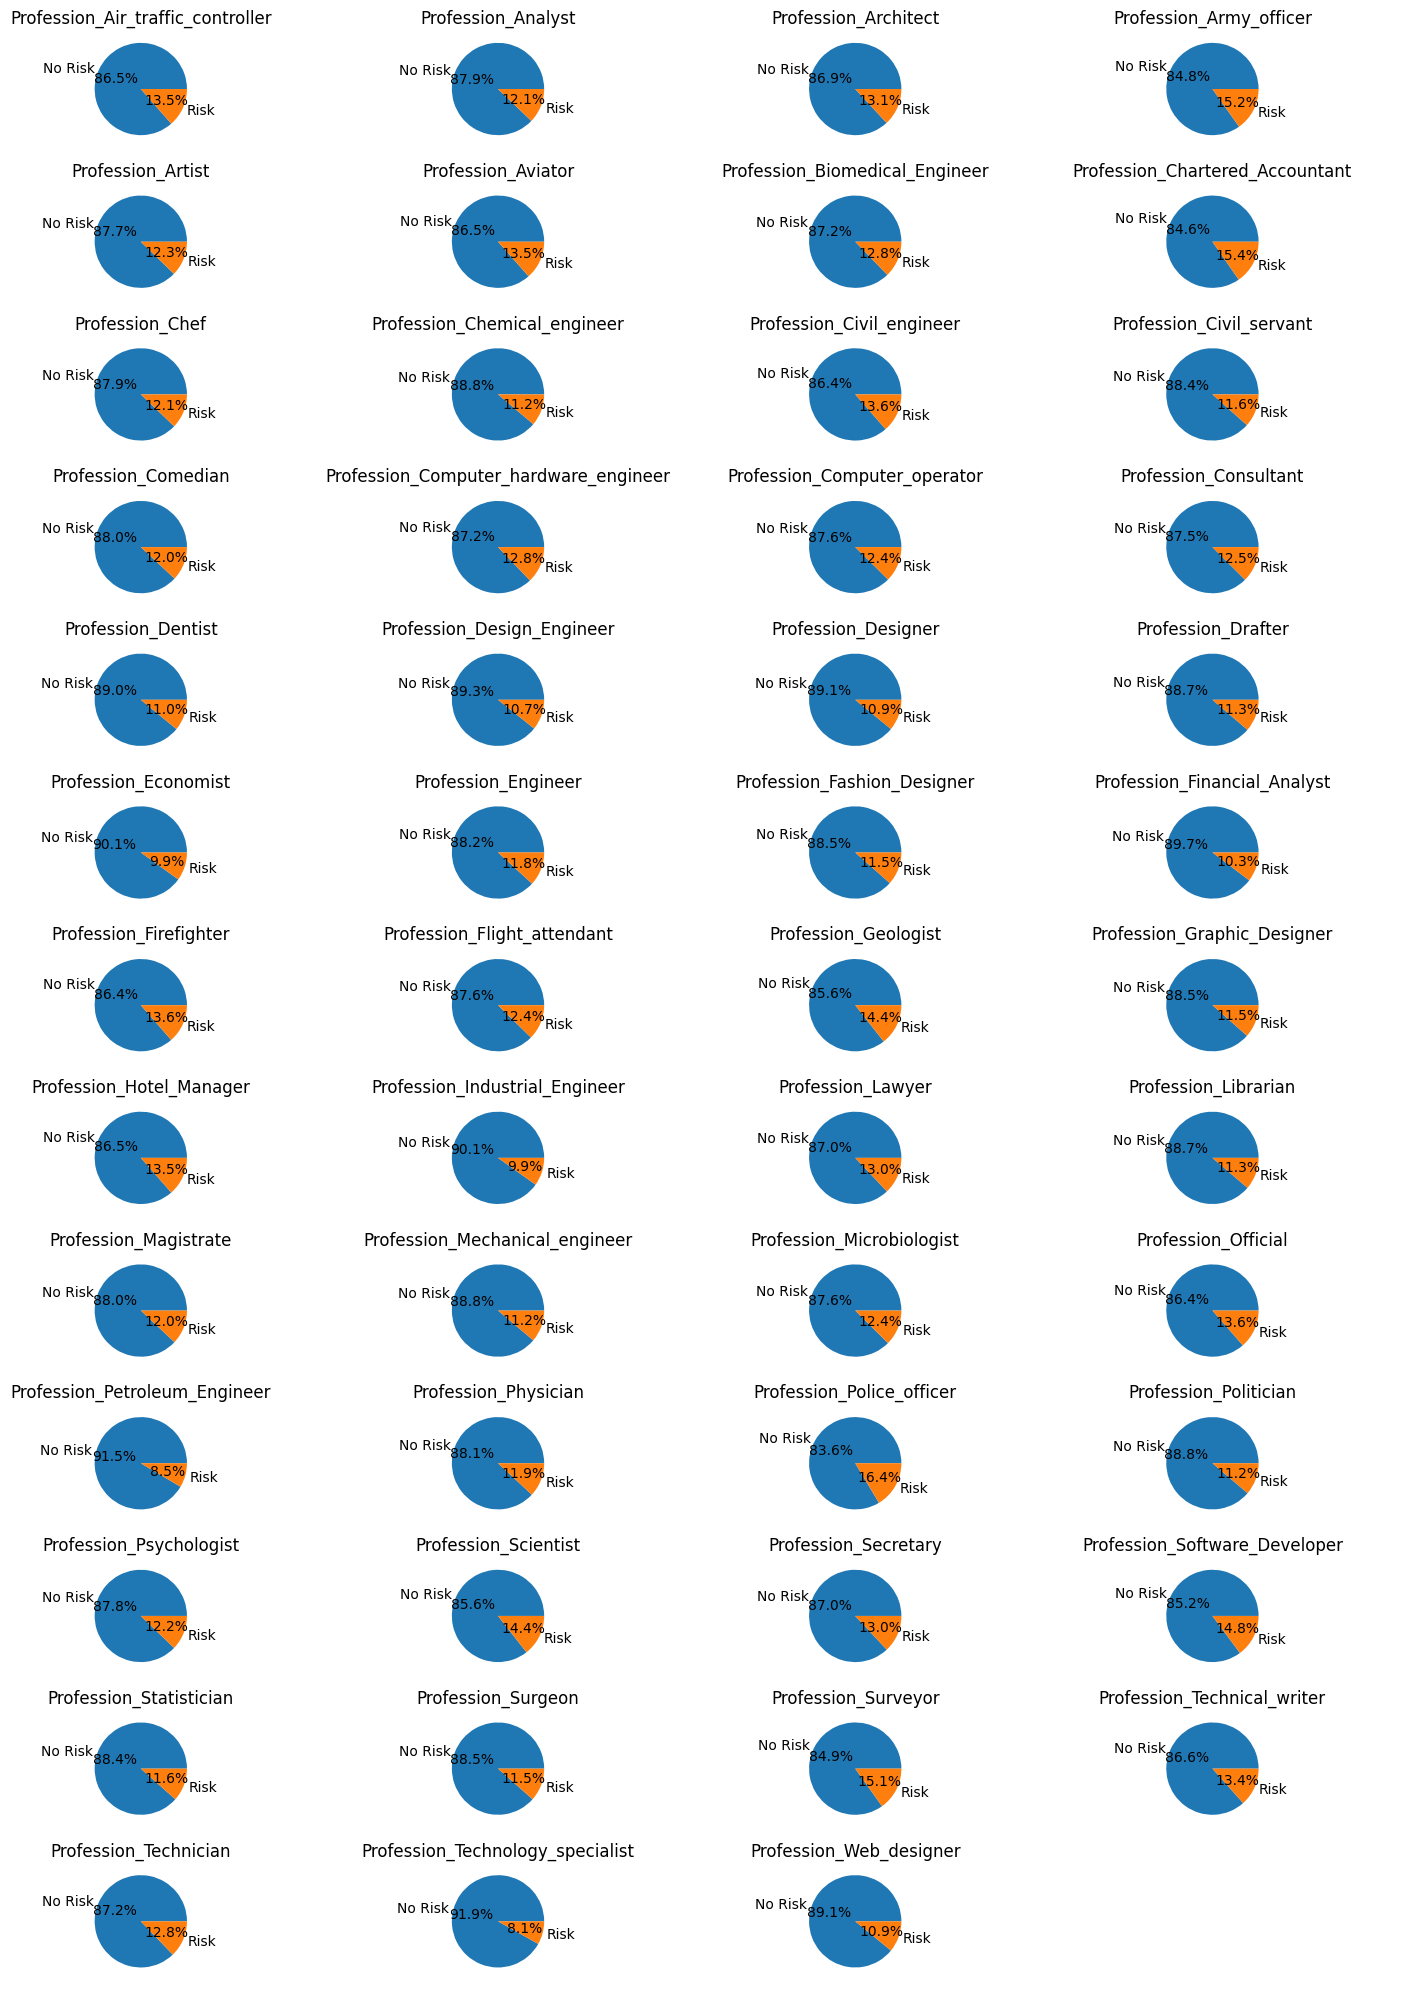

In [112]:
def risk_flag_profession(professions):
    n = len(professions)
    row=math.ceil(n/4)
    col=4
    
    fig, axs = plt.subplots(row,col, figsize=(15, 20))
    axs = axs.flatten()
    
    for i, profession in enumerate(professions):
        df1 = df[df[profession] == 1]
        risk_counts = df1['Risk_Flag'].value_counts(normalize=True)
        axs[i].pie(risk_counts, labels=['No Risk', 'Risk'], autopct='%1.1f%%')
        axs[i].set_title(f"{profession}")
    
    for j in range(i + 1, len(axs)):
        axs[j].axis('off')
    
    plt.tight_layout()
    plt.show()

risk_flag_profession(professions)

Police officer is most risky with 16.4% of risk flag.\
Technology Specialist is least risky with 8.1% of risk flag.

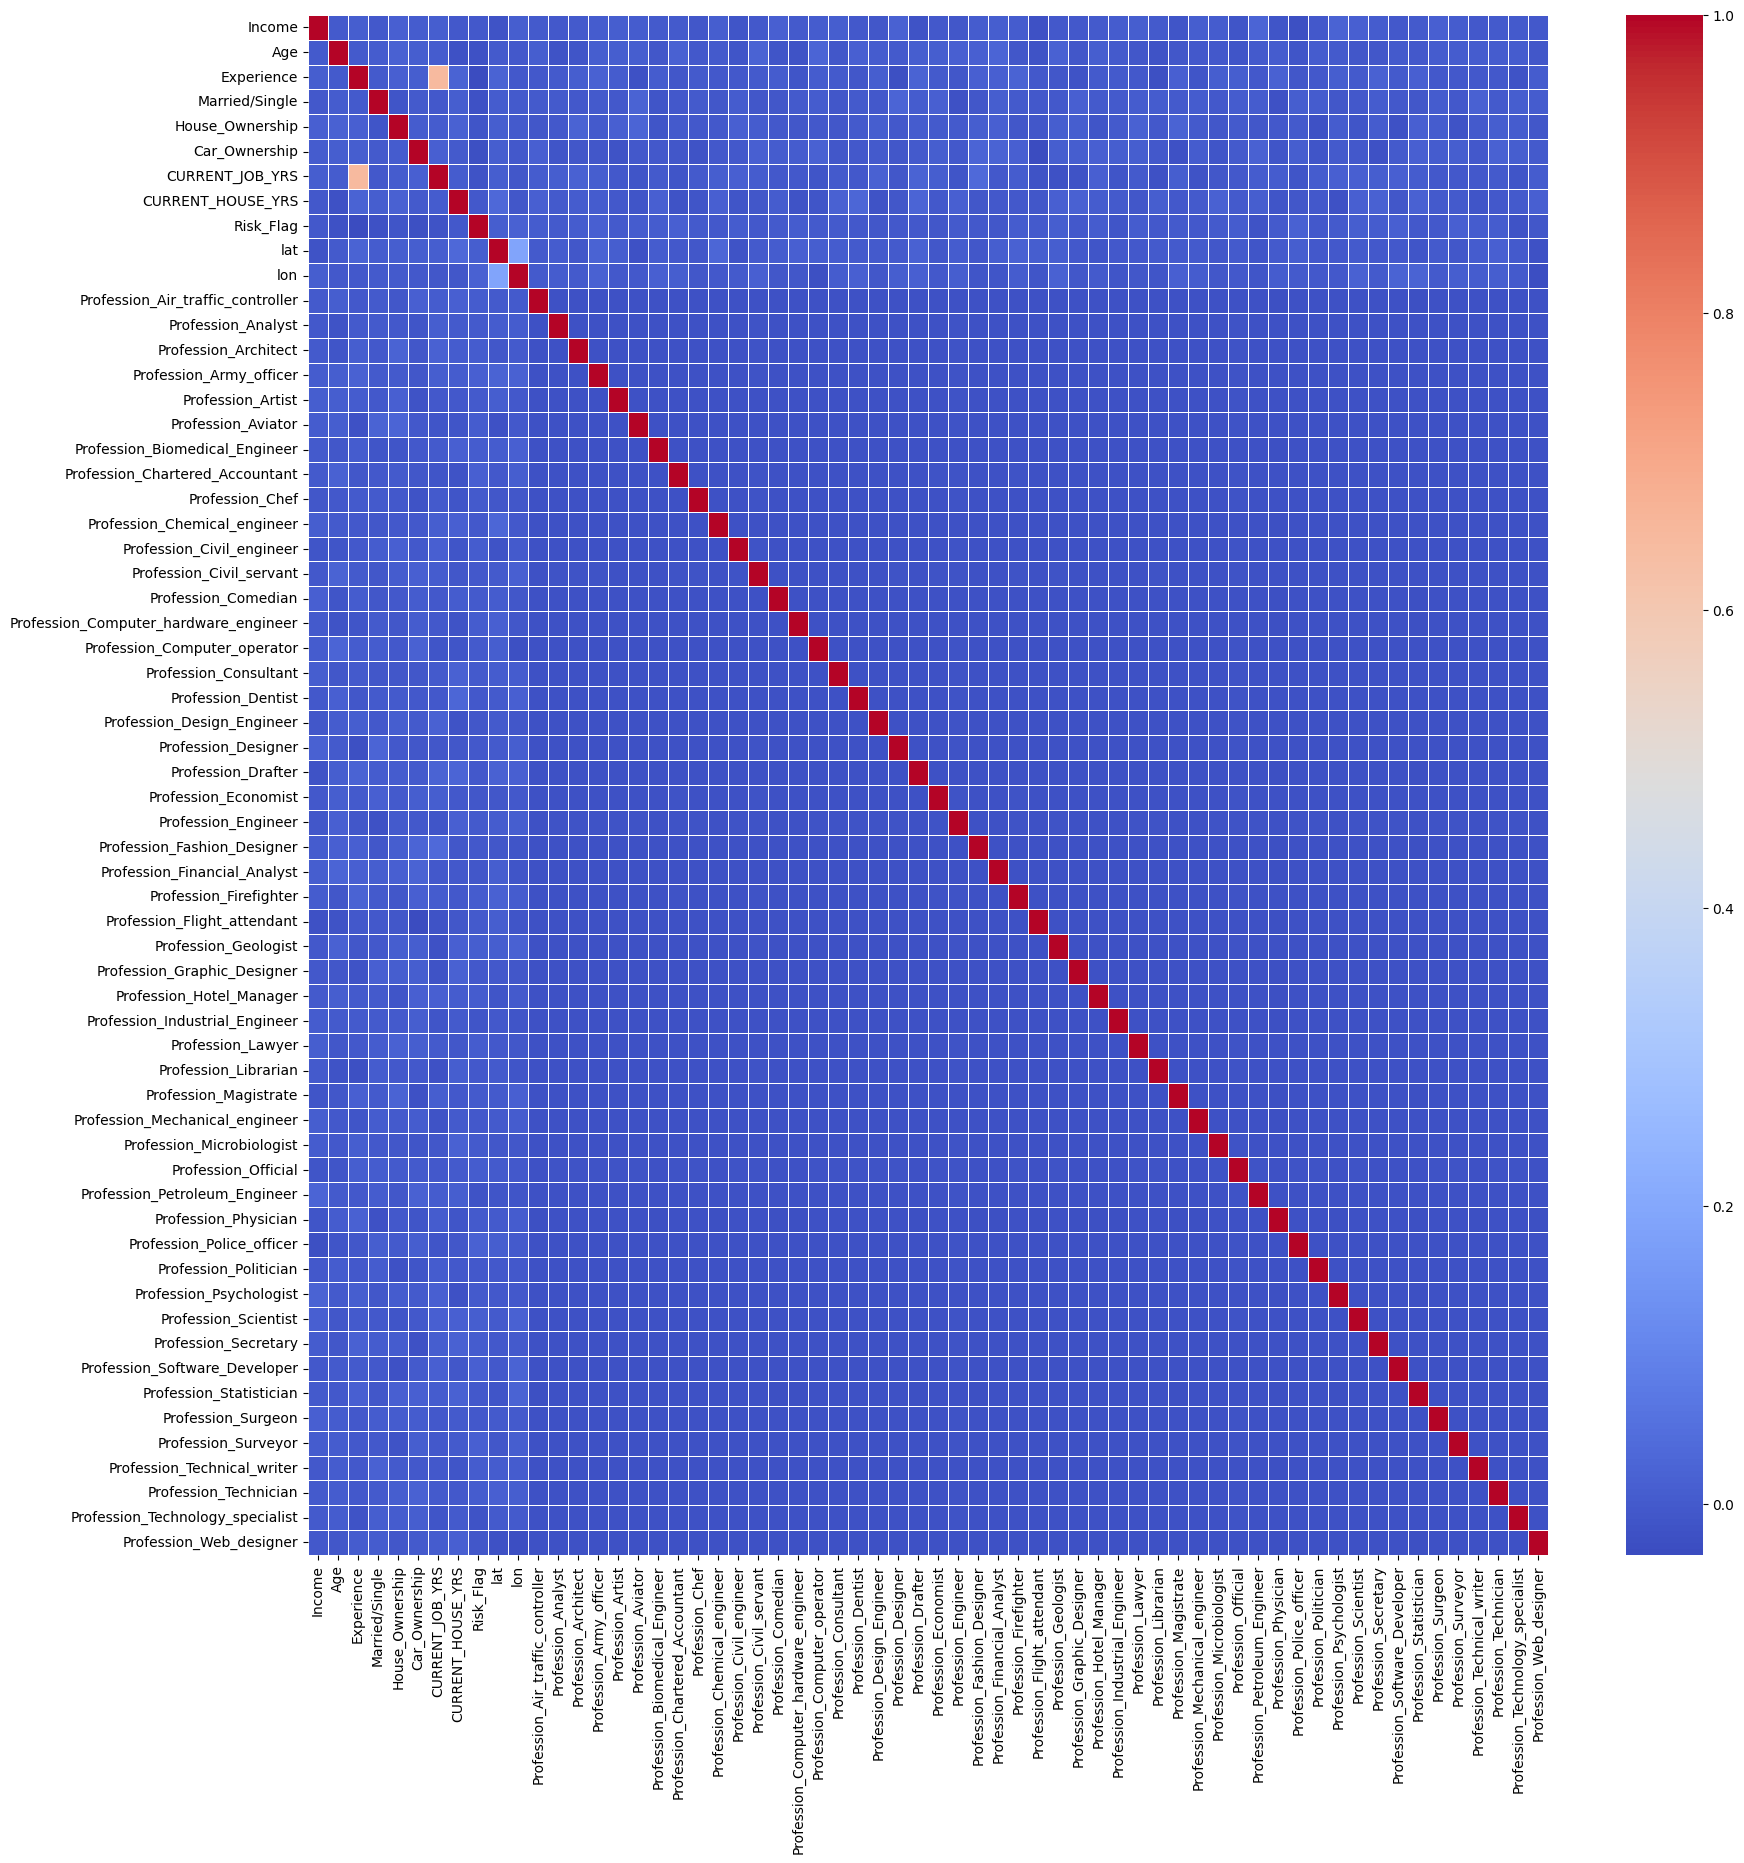

In [44]:
plt.figure(figsize=(20,20))
sns.heatmap(df.corr(),annot=False,cmap='coolwarm',linewidths=0.5)
plt.show()

In [45]:
df.to_csv('./cleaned_data.csv',index=False)

In [46]:
counts=df['Risk_Flag'].value_counts()
print(counts)

Risk_Flag
0    221003
1     30996
Name: count, dtype: int64


<Axes: xlabel='Risk_Flag', ylabel='count'>

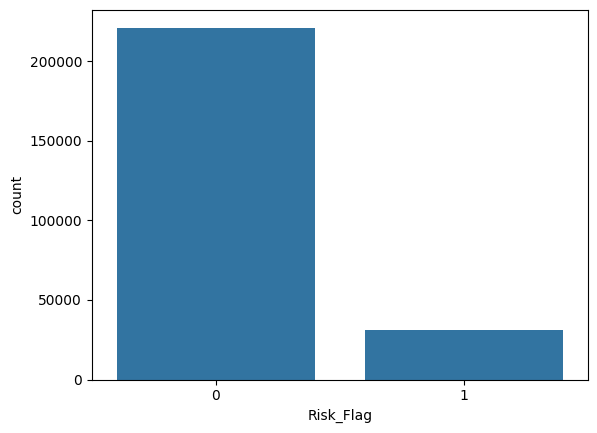

In [47]:
sns.countplot(x='Risk_Flag',data=df)

Clearly data is imbalanced.

In [127]:
df.head()

,Income,Age,Experience,Married/Single,House_Ownership,Car_Ownership,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag,lat,...,Profession_Scientist,Profession_Secretary,Profession_Software_Developer,Profession_Statistician,Profession_Surgeon,Profession_Surveyor,Profession_Technical_writer,Profession_Technician,Profession_Technology_specialist,Profession_Web_designer
0,7574516,40,10,0,0,0,9,13,0,19.262469,...,False,False,True,False,False,False,False,False,False,False
1,3991815,66,4,1,0,0,4,10,0,9.498000,...,False,False,False,False,False,False,True,False,False,False
2,6256451,41,2,0,0,1,2,12,1,20.260296,...,False,False,True,False,False,False,False,False,False,False
3,5768871,47,11,0,0,0,3,14,1,10.804973,...,False,False,False,False,False,False,False,False,False,False
4,6915937,64,0,0,0,0,0,12,0,21.013761,...,False,False,False,False,False,False,False,False,False,False


In [125]:
# outlier detection
def plot_box():
    fig, axs = plt.subplots(3,3, figsize=(10,10))
    axs = axs.flatten()
    cols=['Income', 'Age', 'Experience', 'Married/Single', 'House_Ownership',
       'Car_Ownership', 'CURRENT_JOB_YRS',
       'CURRENT_HOUSE_YRS']
    for i, col in enumerate(cols):
        axs[i].boxplot(df[col])
        axs[i].set_title(f"{col}")
    plt.show()

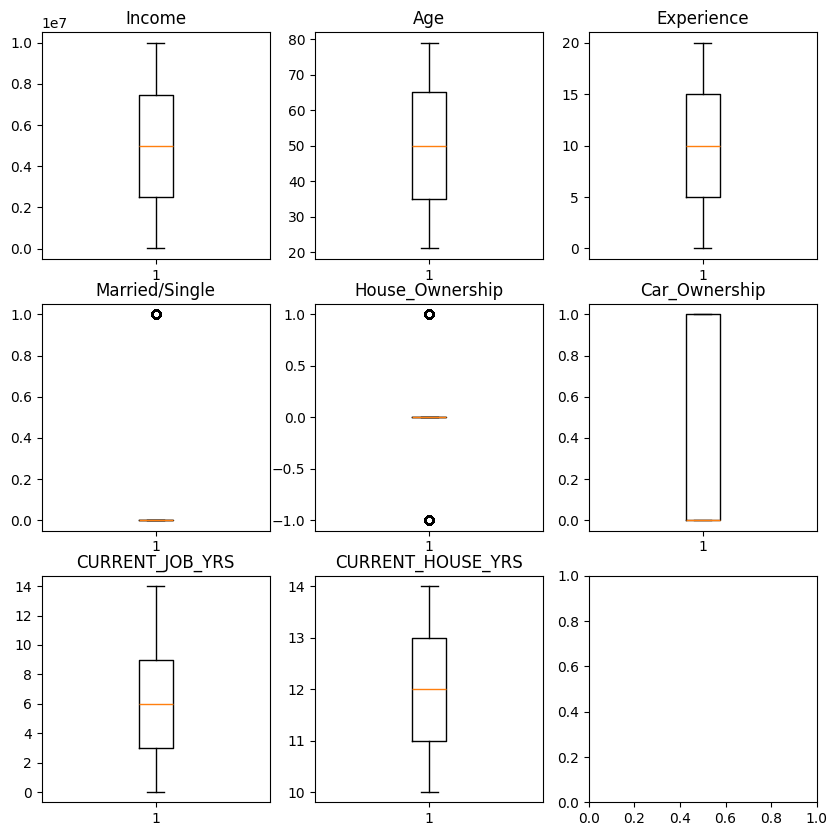

In [126]:
plot_box()

We do not have any outliers in the data.\
Since our dataset is imbalanced so we have to do resample our data.


In [128]:
df1=df[df['Risk_Flag']==1]
df0=df[df['Risk_Flag']==0]
df1.shape,df0.shape

((30996, 62), (221003, 62))

In [129]:
# we will consider 30000 of each class
df1=df1.sample(30000)
df0=df0.sample(30000)
new_df=pd.concat([df1,df0],axis=0)

In [131]:
new_df.shape

(60000, 62)

In [132]:
new_df.head()

,Income,Age,Experience,Married/Single,House_Ownership,Car_Ownership,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag,lat,...,Profession_Scientist,Profession_Secretary,Profession_Software_Developer,Profession_Statistician,Profession_Surgeon,Profession_Surveyor,Profession_Technical_writer,Profession_Technician,Profession_Technology_specialist,Profession_Web_designer
13457,4613553,27,13,0,1,0,13,10,1,12.305183,...,False,False,False,False,False,False,False,False,False,False
227630,2092479,78,12,0,0,0,6,10,1,18.973354,...,False,False,False,False,False,False,False,False,False,False
109801,5832406,24,4,0,0,1,4,12,1,16.850253,...,False,False,False,False,False,False,False,False,False,False
35238,2755203,64,15,0,0,0,11,12,1,19.172572,...,False,False,False,False,False,False,False,False,False,False
180067,4514928,28,20,0,0,1,5,11,1,20.260296,...,False,False,True,False,False,False,False,False,False,False


In [133]:
new_df.to_csv('./balanced_data.csv',index=False)

Since dimensionality of our data is quite high so we will use PCA to reduce the dimensionality.

In [134]:
target=new_df['Risk_Flag']
new_df.drop(labels=['Risk_Flag'],axis=1,inplace=True)

In [143]:
# perform PCA
pca = PCA(n_components=4)
principalComponents = pca.fit_transform(new_df)

In [144]:
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2','principal component 3','principal component 4'])

# Fitting and selection of the best model

In [146]:
x_train,x_test,y_train,y_test=train_test_split(principalDf,target,test_size=0.2,random_state=42)

### Logistic regression

In [153]:
logistic_model=LogisticRegression()

In [154]:
logistic_model.fit(x_train,y_train)

LogisticRegression()

In [155]:
y_pred=logistic_model.predict(x_test)

In [156]:
metrics.accuracy_score(y_test,y_pred)

0.5184166666666666

it is slightly better than a random guess.\
now let's try this with original data(without pca)

In [165]:
logistic_model2=LogisticRegression(penalty='l1',solver='liblinear') 

In [166]:
logistic_model2.fit(x_train,y_train)
y_pred=logistic_model2.predict(x_test)
metrics.accuracy_score(y_test,y_pred)

0.51375

In [167]:
# let us try to fit it directly without pca
x_train1,x_test1,y_train1,y_test1=train_test_split(new_df,target,test_size=0.2,random_state=45)

In [170]:
logistic_model3=LogisticRegression(max_iter=1000)

In [174]:
logistic_model3.fit(x_train1,y_train1)
y_pred=logistic_model3.predict(x_test1)

In [173]:

print(metrics.classification_report(y_test1,y_pred))

              precision    recall  f1-score   support

           0       0.52      0.51      0.51      5966
           1       0.53      0.54      0.54      6034

    accuracy                           0.53     12000
   macro avg       0.52      0.52      0.52     12000
weighted avg       0.52      0.53      0.52     12000



it is also same.

### K-Neighbors

In [176]:
kn_model1=KNeighborsClassifier()
kn_model2=KNeighborsClassifier()

In [177]:
kn_model1.fit(x_train,y_train)
y_pred=kn_model1.predict(x_test)
print(metrics.classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.83      0.85      0.84      6091
           1       0.84      0.82      0.83      5909

    accuracy                           0.84     12000
   macro avg       0.84      0.84      0.84     12000
weighted avg       0.84      0.84      0.84     12000



In [178]:
kn_model2.fit(x_train1,y_train1)
y_pred=kn_model2.predict(x_test1)
print(metrics.classification_report(y_test1,y_pred))

              precision    recall  f1-score   support

           0       0.83      0.84      0.84      5966
           1       0.84      0.83      0.84      6034

    accuracy                           0.84     12000
   macro avg       0.84      0.84      0.84     12000
weighted avg       0.84      0.84      0.84     12000



K-neighbors has higher accuracy in both type of data.

### Support Vector Classifier

In [181]:
svc1=SVC()
svc2=SVC()

In [182]:
svc1.fit(x_train,y_train)
y_pred=svc1.predict(x_test)
print(metrics.classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.51      0.65      0.57      6091
           1       0.50      0.37      0.42      5909

    accuracy                           0.51     12000
   macro avg       0.51      0.51      0.50     12000
weighted avg       0.51      0.51      0.50     12000



In [184]:
svc2.fit(x_train1,y_train1)
y_pred=svc2.predict(x_test1)
print(metrics.classification_report(y_test1,y_pred))

              precision    recall  f1-score   support

           0       0.50      0.78      0.61      5966
           1       0.52      0.24      0.33      6034

    accuracy                           0.51     12000
   macro avg       0.51      0.51      0.47     12000
weighted avg       0.51      0.51      0.47     12000



In [185]:
svc3=SVC(kernel='poly')
svc3.fit(x_train,y_train)
y_pred=svc3.predict(x_test)
print(metrics.classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.52      0.38      0.44      6091
           1       0.50      0.63      0.56      5909

    accuracy                           0.50     12000
   macro avg       0.51      0.51      0.50     12000
weighted avg       0.51      0.50      0.50     12000



support vector classifier's performance is poor.

### Decision Tree Classifier

In [187]:
tree_model=DecisionTreeClassifier()

In [188]:
params={
    'max_depth':[2,3,4,5,6,7,8,9,10],
    'criterion':['gini','entropy']
}

In [190]:
clf=GridSearchCV(tree_model,param_grid=params,cv=5)

In [191]:
clf.fit(x_train,y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10]})

In [192]:
clf.best_params_

{'criterion': 'gini', 'max_depth': 10}

In [193]:
tree_model=DecisionTreeClassifier(max_depth=10,criterion='gini')
tree_model.fit(x_train,y_train)
y_pred=tree_model.predict(x_test)
print(metrics.classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.59      0.78      0.67      6091
           1       0.66      0.44      0.53      5909

    accuracy                           0.61     12000
   macro avg       0.62      0.61      0.60     12000
weighted avg       0.62      0.61      0.60     12000



Decision Tree has a slighly better accuracy than other models.

### Adaboost Classifier

In [206]:
adaboot_model=AdaBoostClassifier(estimator=tree_model,n_estimators=50,learning_rate=1.0)
adaboot_model.fit(x_train,y_train)
y_pred=adaboot_model.predict(x_test)
print(metrics.classification_report(y_test,y_pred))


d:\Programs\Python\PW\projects\NLP\env\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.86      0.86      0.86      6091
           1       0.86      0.86      0.86      5909

    accuracy                           0.86     12000
   macro avg       0.86      0.86      0.86     12000
weighted avg       0.86      0.86      0.86     12000



It's accuracy is better than others.

In [197]:
randomforest_model=RandomForestClassifier()
randomforest_model.fit(x_train,y_train)
y_pred=randomforest_model.predict(x_test)
print(metrics.classification_report(y_test,y_pred))


              precision    recall  f1-score   support

           0       0.84      0.88      0.86      6091
           1       0.87      0.83      0.85      5909

    accuracy                           0.85     12000
   macro avg       0.85      0.85      0.85     12000
weighted avg       0.85      0.85      0.85     12000



In [199]:
randomforest_model=RandomForestClassifier(criterion='entropy',n_estimators=100)
randomforest_model.fit(x_train,y_train)
y_pred=randomforest_model.predict(x_test)
print(metrics.classification_report(y_test,y_pred))


              precision    recall  f1-score   support

           0       0.84      0.88      0.86      6091
           1       0.87      0.83      0.85      5909

    accuracy                           0.85     12000
   macro avg       0.85      0.85      0.85     12000
weighted avg       0.85      0.85      0.85     12000



In [200]:
gradient_boost_model=GradientBoostingClassifier()
gradient_boost_model.fit(x_train,y_train)
y_pred=gradient_boost_model.predict(x_test)
print(metrics.classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.61      0.67      0.64      6091
           1       0.62      0.56      0.59      5909

    accuracy                           0.61     12000
   macro avg       0.62      0.61      0.61     12000
weighted avg       0.62      0.61      0.61     12000



## Conclusion
Overall we have adaboost as best model. Although we can further try deep learning based models for better accuracy. Adaboost model has accuracy 86% and precision and recall both are 86%. Here we are predicting the positiveness of the test example whether it is risky or not. So positive class is more important for us and give preference to the precision over recall. Adaboost model has the best precion.